In [7]:
import tensorflow as tf
import cv2
import numpy as np
import argparse
import csv
import os
import math
from tensorflow.python.platform import gfile
from common import estimate_pose, draw_humans, read_imgfile
import time
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [8]:
def savevid(vidpath):
    vidcap = cv2.VideoCapture(vidpath)
    vidbase = os.path.split(vidpath)[1].split(".")[0]    
    outvid = []
    
    while(vidcap.isOpened()):
        ret, frame = vidcap.read()
        if ret == False:
            break
        outvid.append(frame)
   
    vidcap.release()
    cv2.destroyAllWindows()
    return outvid

def writevid(vid, outvidpath):
     #Look at imageshape output and take size from there (reversed)
    H = vid[1].shape[0]
    W = vid[1].shape[1]
    numframes = len(vid)
    vidwriter = cv2.VideoWriter(outvidpath, cv2.VideoWriter_fourcc(*'MP4V'),10, (W, H))

    for i in range(1, numframes):
        if i%10==0:
            print("FRAME" , i, "/", numframes)        
        vidwriter.write(vid[i])
               
    vidwriter.release()
    cv2.destroyAllWindows()
    
def make_ellipse(image, row):
    center = (int(round(row[0])),int(round(row[1])))
    axes = (int(round(row[2])),int(round(row[3])))
    color = (255,255,255)
    angle = int(round(row[4] * 180 / math.pi))

    return cv2.ellipse(image, center, axes, angle, 0, 360, color, -1)     
    
    
def makeMask(tubefile, in_height=720, in_width=1280):
    #Later we will update to handle CSVs and txt files, but be cool....
    
    THEMASK = []
    #THEMASK = np.zeros((in_height, in_width,3,numframes), dtype=np.uint8)

    D = np.genfromtxt(tubefile) #Got the data!
    numframes = int(max(D[:,5]))
    
    for f in range(0,numframes):
        frame = np.zeros((in_height, in_width,3), np.uint8)
        d = [row for row in D if row[5]==f] #list of rows this frame
        
        for row in d:
            frame = make_ellipse(frame,row)
           
        THEMASK.append(frame)

    return THEMASK
    
    
def readtubelist(tubelistpath):
    #Make the option for CSV files
    if  tubelistpath.split(".")[-1] == "txt":
        wholedata = np.genfromtxt(tubelistpath) #Got the data!
        numtubes = int(wholedata[-1,-1]) #total num of tubes

        tubelist = {t: [row for row in wholedata if row[-1]==t] for t in range(0,numtubes)} 
        
    elif tubelistpath.split(".")[-1]== "csv":
        with open(tubelistpath) as csvfile:
            readCSV = csv.reader(csvfile, delimiter=',')
            next(readCSV) #burn the first line
            
            tubes = []
            wholedata =[]
            for row in readCSV:
                row = [float(i) for i in row]
                wholedata.append(row[1:])
                if row[-1] not in tubes:
                    tubes.append(row[-1])
                
        wholedata = np.asarray(wholedata)
        print(tubes)
        numtubes = len(tubes) #total num of tubes

        tubelist = {tubes.index(t): [row for row in wholedata if row[-1] ==t] for t in tubes} 
    
    else:
        print("We only do .txt and .csv files. Sorry.")
        tubelist = []
        wholedata =np.asarray([])
    
        
    return tubelist, wholedata


def getBoxFromEllipse(row, option):
    # Bounding box is normally (xmin, ymin, width, height) 
    if option ==0:
        #Top half of straight ellipse
        bbox = (int(row[0]-row[3]), int(row[1] - row[2]), int(2*row[3]), int(row[2]))
    elif option==1:
        #Top right quarter of straight ellipse (works for t3)
        bbox = (int(row[0]), int(row[1] - row[2]), int(row[3]), int(row[2]))
    elif option==2:
        #Bottom half of straight ellipse
        bbox = (int(row[0]-row[3]), int(row[1]), int(2*row[3]), int(row[2]))
    elif option==3:
        #Top half (tighter) of straight ellipse
        bbox = (int(row[0]-1.5*row[3]), int(row[1] - row[2]), int(3*row[3]), int(row[2]))
    else:
        #Bottom right half of straight ellipse
        bbox = (int(row[0]), int(row[1]), int(row[3]), int(row[2]))
    
    #Definitely should make more options
    return bbox

def getFourBoxes(row):
    bbox1 = (int(row[0]-row[3]), int(row[1] - row[2]), int(row[3]), int(row[2]))  #top left
    bbox2 = (int(row[0]), int(row[1] - row[2]), int(row[3]), int(row[2]))        #top right
    bbox3 = (int(row[0]-row[3]), int(row[1]), int(row[3]), int(row[2]))        #bttm left
    bbox4 = (int(row[0]), int(row[1]), int(row[3]), int(row[2]))              #bttm right
    
    return bbox1, bbox2, bbox3, bbox4


def plotTracks(tracks):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r','g','b','c','m','y','k','xkcd:baby blue','xkcd:sand','xkcd:mint','xkcd:wine red']

    for tr in tracks:
        ts =[row[0] for row in tr]
        xs =[(row[1][0] + row[1][2]/2) for row in tr]
        ys =[(row[1][1] + row[1][3]/2) for row in tr]
        ax.scatter(ts,xs,ys, c=random.choice(colors),marker='.')
        
    ax.set_xlabel('Time')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    plt.show()
    
def noSmallTubes(tracks):
    newtracks = [T for T in tracks if len(T) > 60]
    return newtracks
            
    


In [103]:
# Setup
#vidpath = "int6.mp4"
#vidbase = os.path.split(vidpath)[1].split(".")[0]
#outvidfile = vidbase + '_CSRTbegK10.mp4'
#tubefile = vidbase + '_tubelist.txt'

vidpath = "ski5.mp4"
vidbase = os.path.split(vidpath)[1].split(".")[0]
outvidfile = vidbase + '_pureCSRTmid.mp4'
tubefile = vidbase + '_tubelistv1.csv'

# Read in info
V = savevid(vidpath)
T, Tdata = readtubelist(tubefile)

'''
M = makeMask(tubefile)

VM = []
for f in range(0,len(V)):
    if f < len(M):
        slice = cv2.bitwise_and(V[f],V[f],mask=M[f][:,:,0])
    else:
        slice = V[f]
    VM.append(slice)


#writevid(VM,'int6_Kvid.mp4')

'''

# CHOOSE THE TRACKER STYLE TO EMPLOY THE TUBES
#0: 1 box pure KCF
#1: 4 box pure KCF
#2: 1 box KCF until failure, then use tube
#3: 1 box KCF. Every K frames, force box to tube
#4: 4 box KCF. Every K frames, force boxes to tube
#5: 1 box KCF. Every K frames, force box to tube. Use tube upon failure
#6: 1 box pure tube

trackerstyle = 5

print(type(V))
print(type(V[0]))
print(V[0].shape)

# Getting rid of short BS tubes
#for key in [key for key in T if len(T[key]) < 60]: del T[key] 


[2.0, 4.0, 21.0, 9.0, 3.0, 1.0, 22.0, 5.0, 8.0, 10.0, 13.0, 15.0, 16.0, 23.0, 24.0, 25.0, 27.0]
<class 'list'>
<class 'numpy.ndarray'>
(720, 1280, 3)


In [104]:
# Making a new tracker... this one should initialize in the middle and track outwards both ways... 
# Using the KCF tracker (at least for now) because the MIL tracker murders the kernel.

t0 = time.time()
tracks = []
pureTracker = True

if not(pureTracker):
    #For each tube t, if it's longer than 60 frames
    for t in range(0,len(T)):
        if len(T[t]) > 60:
            K = 10
            tracker = cv2.TrackerCSRT_create()
            start = T[t][math.floor(len(T[t])/2)] #middle ellipse of tube
            startf = start[5]
            thistrack = []
            hassplit=False

            #Start the tracker here
            bbox = getBoxFromEllipse(start, 0)
            print("Tube ",t,"first Bbox:", bbox)
            ok = tracker.init(V[int(startf)], bbox)
            thistrack.append((int(startf), bbox, 2))

            for i in range(1,math.floor(len(T[t])/2)): #for each frame in tube

                if i%K==0: #Every K frames...
                    hassplit = True
                    Rb = [row for row in T[t] if row[5]==startf-i][0]
                    Rf = [row for row in T[t] if row[5]==startf+i][0]
                    bboxb = getBoxFromEllipse(Rb ,0)
                    bboxf = getBoxFromEllipse(Rf ,0)

                    trackerb = cv2.TrackerCSRT_create()
                    trackerb.init(V[int(startf-i)], bboxb)
                    trackerf = cv2.TrackerCSRT_create()
                    trackerf.init(V[int(startf+i)], bboxf)
                    thistrack.append((int(startf-i), bboxb, 2))
                    thistrack.append((int(startf+i), bboxf, 2))

                else:
                    if not(hassplit):  # Update tracker
                        okb, bboxb = tracker.update(V[int(startf - i)])
                        okf, bboxf = tracker.update(V[int(startf + i)])
                    else:
                        okb, bboxb = trackerb.update(V[int(startf - i)])
                        okf, bboxf = trackerf.update(V[int(startf + i)])

                    if okb:
                        thistrack.append((int(startf-i), bboxb, 1))
                    else:
                        Rb = [row for row in T[t] if row[5]==startf-i][0]
                        bboxb = getBoxFromEllipse(Rb ,0)
                        thistrack.append((int(startf-i), bboxb, 0)) 

                    if okf:
                        thistrack.append((int(startf+i), bboxf, 1))
                    else:
                        Rf = [row for row in T[t] if row[5]==startf+i][0]
                        bboxf = getBoxFromEllipse(Rf ,0)
                        thistrack.append((int(startf+i), bboxf, 0)) 

            tracks.append(thistrack)
            
else:   #JUST THE PURE TRACKER
    #For each tube t, if it's longer than 60 frames
    for t in range(0,len(T)):
        if len(T[t]) > 60:
            trackerb = cv2.TrackerCSRT_create()
            trackerf = cv2.TrackerCSRT_create()
            start = T[t][math.floor(len(T[t])/2)] #middle ellipse of tube
            startf = start[5]
            thistrack = []

            #Start the tracker here
            bbox = getBoxFromEllipse(start, 0)
            okb = trackerb.init(V[int(startf)], bbox)
            okf = trackerf.init(V[int(startf)], bbox)
            thistrack.append((int(startf), bbox, 2))
            print("Tube ",t,"first Bbox:", bbox)
            

            for i in range(1,math.floor(len(T[t])/2)): #for each frame in tube

                okb, bboxb = trackerb.update(V[int(startf - i)])
                okf, bboxf = trackerf.update(V[int(startf + i)])

                if okb:
                    thistrack.append((int(startf-i), bboxb, 1))
                
                if okf:
                    thistrack.append((int(startf+i), bboxf, 1))
               
        tracks.append(thistrack)
    
    
    
    
 
t1 = time.time()
print("Total time: ", (t1-t0), "seconds")

Tube  0 first Bbox: (221, 310, 35, 24)
Tube  1 first Bbox: (516, 584, 39, 23)
Tube  2 first Bbox: (312, 515, 27, 15)
Tube  3 first Bbox: (565, 559, 30, 21)
Tube  4 first Bbox: (237, 448, 33, 21)
Tube  5 first Bbox: (612, 172, 28, 17)
Tube  6 first Bbox: (564, 542, 32, 21)
Tube  7 first Bbox: (1110, 654, 40, 27)
Tube  8 first Bbox: (757, 408, 34, 26)
Tube  9 first Bbox: (455, 181, 21, 20)
Tube  10 first Bbox: (330, 649, 33, 24)
Tube  11 first Bbox: (272, 641, 39, 24)
Tube  12 first Bbox: (482, 520, 20, 11)
Tube  13 first Bbox: (791, 165, 34, 17)
Tube  14 first Bbox: (515, 148, 25, 14)
Tube  15 first Bbox: (1143, 368, 38, 26)
Tube  16 first Bbox: (591, 145, 31, 38)
Total time:  415.72653365135193 seconds


In [98]:
if trackerstyle == 0:    
    # Tracker Style KCF: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure. One box.
    
    t0 = time.time()
    tracker = cv2.TrackerCSRT_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if (len(T[t]) > 60) and not(t==2):
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start, 0)
            print("Tube ",t,"first Bbox:", bbox)

            ok = tracker.init(V[int(startf)], bbox)
            thistrack.append((int(startf), bbox, 1))


            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok, bbox = tracker.update(V[int(startf + i)])

                if ok:
                    thistrack.append((int(startf+i), bbox, 1))


            tracks.append(thistrack)
            tracker = cv2.TrackerCSRT_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==1:
    # Tracker Style KCF: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure. Four boxes

    t0 = time.time()
    tracker1 = cv2.TrackerMIL_create()
    tracker2 = cv2.TrackerMIL_create()
    tracker3 = cv2.TrackerMIL_create()
    tracker4 = cv2.TrackerMIL_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox1, bbox2, bbox3, bbox4 = getFourBoxes(start)
            print("Tube ",t,"first Bbox:", bbox1)

            ok1 = tracker1.init(V[int(startf)], bbox1)
            ok2 = tracker2.init(V[int(startf)], bbox2)
            ok3 = tracker3.init(V[int(startf)], bbox3)
            ok4 = tracker4.init(V[int(startf)], bbox4)

            thistrack.append((int(startf), bbox1, 1))
            thistrack.append((int(startf), bbox2, 1))
            thistrack.append((int(startf), bbox3, 1))
            thistrack.append((int(startf), bbox4, 1))

            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok1, bbox1 = tracker1.update(V[int(startf + i)])
                ok2, bbox2 = tracker2.update(V[int(startf + i)])
                ok3, bbox3 = tracker3.update(V[int(startf + i)])
                ok4, bbox4 = tracker4.update(V[int(startf + i)])

                if ok1:
                    thistrack.append((int(startf+i), bbox1, 1))
                if ok2:
                    thistrack.append((int(startf+i), bbox2, 1))
                if ok3:
                    thistrack.append((int(startf+i), bbox3, 1))
                if ok4:
                    thistrack.append((int(startf+i), bbox4, 1))


            tracks.append(thistrack)
            tracker1 = cv2.TrackerMIL_create()
            tracker2 = cv2.TrackerMIL_create()
            tracker3 = cv2.TrackerMIL_create()
            tracker4 = cv2.TrackerMIL_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==2:
    # Tracker Style 1: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure.
    # Upon failure, use the tube to guide the b-box (red box)--------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    t0 = time.time()
    tracker = cv2.TrackerMIL_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)

            ok = tracker.init(V[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 1))

            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok, bbox = tracker.update(V[int(startf + i)])

                if ok:
                    thistrack.append((int(startf+i), bbox, 1))

                else:
                    # Tracking failure
                    #cv2.putText(V[int(startf + i)], "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                    #BUT THEN FIX IT
                    #cv2.putText(V[int(startf + i)], "Fixing...", (100,120), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                    R = [row for row in T[t] if row[5]==startf+i][0]
                    bbox = getBoxFromEllipse(R,0)
                    tracker.init(V[int(startf+i)], bbox)
                    thistrack.append((int(startf+i), bbox, 0))

            tracks.append(thistrack)
            tracker = cv2.TrackerMIL_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==3:
    # Tracker Style 2: Initialize a bounding box on the first ellipse of the tube. KCF track for K frames. Every K frames, 
    # reset tracker based on tube. (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker = cv2.TrackerMIL_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox = getBoxFromEllipse(start,1)
            print("Tube ",t,"first Bbox:", bbox)
            ok = tracker.init(V[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    #tracker= cv2.TrackerMIL_create()
                    R = [row for row in T[t] if row[5]==f][0]
                    bbox = getBoxFromEllipse(R ,1)
                    tracker.init(V[int(f)], bbox)
                    thistrack.append((int(f), bbox, 2))
                else:
                    # Update tracker
                    ok, bbox = tracker.update(V[int(f)])
                    if ok:
                        thistrack.append((int(f), bbox, 1))

                    else:
                        # Tracking failure
                        #cv2.putText(V[int(startf + i)], "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                        #BUT THEN FIX IT
                        #cv2.putText(V[int(startf + i)], "Fixing...", (100,120), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                        print("Womp womp")

            tracks.append(thistrack)
            tracker = cv2.TrackerMIL_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==4:
    # Tracker Style 3: Initialize 4 bounding boxes on the first ellipse of the tube. KCF track for K frames. Every K frames, 
    # reset tracker based on tube. (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker1 = cv2.TrackerMIL_create()
    tracker2 = cv2.TrackerMIL_create()
    tracker3 = cv2.TrackerMIL_create()
    tracker4 = cv2.TrackerMIL_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox1, bbox2, bbox3, bbox4 = getFourBoxes(start)
            print("Tube",t,"initializing")
            ok1 = tracker1.init(V[int(startf)], bbox1)
            ok2 = tracker2.init(V[int(startf)], bbox2)
            ok3 = tracker3.init(V[int(startf)], bbox3)
            ok4 = tracker4.init(V[int(startf)], bbox4)

            thistrack.append((int(startf), bbox1, 2))
            thistrack.append((int(startf), bbox2, 2))
            thistrack.append((int(startf), bbox3, 2))
            thistrack.append((int(startf), bbox4, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    tracker1 = cv2.TrackerMIL_create()
                    tracker2 = cv2.TrackerMIL_create()
                    tracker3 = cv2.TrackerMIL_create()
                    tracker4 = cv2.TrackerMIL_create()

                    R = [row for row in T[t] if row[5]==f][0]
                    bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)

                    tracker1.init(V[int(f)], bbox1)
                    tracker2.init(V[int(f)], bbox2)
                    tracker3.init(V[int(f)], bbox3)
                    tracker4.init(V[int(f)], bbox4)
                    thistrack.append((int(f), bbox1, 2))
                    thistrack.append((int(f), bbox2, 2))
                    thistrack.append((int(f), bbox3, 2))
                    thistrack.append((int(f), bbox4, 2))
                else:
                    # Update tracker
                    ok1, bbox1 = tracker1.update(V[int(f)])
                    ok2, bbox2 = tracker2.update(V[int(f)])
                    ok3, bbox3 = tracker3.update(V[int(f)])
                    ok4, bbox4 = tracker4.update(V[int(f)])

                    R = [row for row in T[t] if row[5]==f][0]

                    if ok1:
                        thistrack.append((int(f), bbox1, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox1, 0))
                    if ok2:
                        thistrack.append((int(f), bbox2, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox2, 0))
                    if ok3:
                        thistrack.append((int(f), bbox3, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox3, 0))
                    if ok4:
                        thistrack.append((int(f), bbox4, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox4, 0))



            tracks.append(thistrack)
            tracker1 = cv2.TrackerMIL_create()
            tracker2 = cv2.TrackerMIL_create()
            tracker3 = cv2.TrackerMIL_create()
            tracker4 = cv2.TrackerMIL_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==5:
    # Tracker Style 4: Initialize a bounding box on the first ellipse of the tube. KCF track for K frames. Keep a wide K.
    # Every K frames, reset tracker based on tube. If u fail, red and fixed to tube (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker = cv2.TrackerCSRT_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)
            ok = tracker.init(V[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    tracker= cv2.TrackerCSRT_create()
                    R = [row for row in T[t] if row[5]==f][0]
                    bbox = getBoxFromEllipse(R ,0)
                    tracker.init(V[int(f)], bbox)
                    thistrack.append((int(f), bbox, 2))
                else:
                    # Update tracker
                    ok, bbox = tracker.update(V[int(f)])
                    if ok:
                        thistrack.append((int(f), bbox, 1))

                    else:
                        R = [row for row in T[t] if row[5]==f][0]
                        bbox = getBoxFromEllipse(R ,0)
                        tracker.init(V[int(f)], bbox)
                        thistrack.append((int(f), bbox, 0))


            tracks.append(thistrack)
            tracker = cv2.TrackerCSRT_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==6:
    # Tracker Style 5: Pure tubes.---------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    t0 = time.time()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)

            for i in range(1,len(T[t])): #for each frame in tube
                    # Update tracker
                    R = [row for row in T[t] if row[5]== startf+i][0]
                    bbox = getBoxFromEllipse(R, 0 )
                    thistrack.append((int(startf+i), bbox, 2))

            tracks.append(thistrack)
           

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")


Tube  0 first Bbox: (856, 301, 51, 39)
Tube  1 first Bbox: (205, 420, 41, 55)
Tube  2 first Bbox: (952, -63, 17, 67)


error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\core\src\matrix.cpp:465: error: (-215:Assertion failed) 0 <= roi.x && 0 <= roi.width && roi.x + roi.width <= m.cols && 0 <= roi.y && 0 <= roi.height && roi.y + roi.height <= m.rows in function 'cv::Mat::Mat'


In [68]:
if trackerstyle == 0:    
    # Tracker Style KCF: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure. One box.
    
    t0 = time.time()
    tracker = cv2.TrackerKCF_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start, 0)
            print("Tube ",t,"first Bbox:", bbox)

            ok = tracker.init(V[int(startf)], bbox)
            thistrack.append((int(startf), bbox, 1))


            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok, bbox = tracker.update(V[int(startf + i)])

                if ok:
                    thistrack.append((int(startf+i), bbox, 1))


            tracks.append(thistrack)
            tracker = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==1:
    # Tracker Style KCF: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure. Four boxes

    t0 = time.time()
    tracker1 = cv2.TrackerKCF_create()
    tracker2 = cv2.TrackerKCF_create()
    tracker3 = cv2.TrackerKCF_create()
    tracker4 = cv2.TrackerKCF_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox1, bbox2, bbox3, bbox4 = getFourBoxes(start)
            print("Tube ",t,"first Bbox:", bbox1)

            ok1 = tracker1.init(V[int(startf)], bbox1)
            ok2 = tracker2.init(V[int(startf)], bbox2)
            ok3 = tracker3.init(V[int(startf)], bbox3)
            ok4 = tracker4.init(V[int(startf)], bbox4)

            thistrack.append((int(startf), bbox1, 1))
            thistrack.append((int(startf), bbox2, 1))
            thistrack.append((int(startf), bbox3, 1))
            thistrack.append((int(startf), bbox4, 1))

            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok1, bbox1 = tracker1.update(V[int(startf + i)])
                ok2, bbox2 = tracker2.update(V[int(startf + i)])
                ok3, bbox3 = tracker3.update(V[int(startf + i)])
                ok4, bbox4 = tracker4.update(V[int(startf + i)])

                if ok1:
                    thistrack.append((int(startf+i), bbox1, 1))
                if ok2:
                    thistrack.append((int(startf+i), bbox2, 1))
                if ok3:
                    thistrack.append((int(startf+i), bbox3, 1))
                if ok4:
                    thistrack.append((int(startf+i), bbox4, 1))


            tracks.append(thistrack)
            tracker1 = cv2.TrackerKCF_create()
            tracker2 = cv2.TrackerKCF_create()
            tracker3 = cv2.TrackerKCF_create()
            tracker4 = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==2:
    # Tracker Style 1: Initialize a bounding box on the first ellipse of the tube. KCF track through until failure.
    # Upon failure, use the tube to guide the b-box (red box)--------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    t0 = time.time()
    tracker = cv2.TrackerKCF_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)

            ok = tracker.init(VM[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 1))

            for i in range(1,len(T[t])): #for each frame in tube
                # Update tracker
                ok, bbox = tracker.update(VM[int(startf + i)])

                if ok:
                    thistrack.append((int(startf+i), bbox, 1))

                else:
                    # Tracking failure
                    #cv2.putText(V[int(startf + i)], "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                    #BUT THEN FIX IT
                    #cv2.putText(V[int(startf + i)], "Fixing...", (100,120), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                    R = [row for row in T[t] if row[5]==startf+i][0]
                    bbox = getBoxFromEllipse(R,0)
                    tracker.init(VM[int(startf+i)], bbox)
                    thistrack.append((int(startf+i), bbox, 0))

            tracks.append(thistrack)
            tracker = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==3:
    # Tracker Style 2: Initialize a bounding box on the first ellipse of the tube. KCF track for K frames. Every K frames, 
    # reset tracker based on tube. (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker = cv2.TrackerKCF_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox = getBoxFromEllipse(start,1)
            print("Tube ",t,"first Bbox:", bbox)
            ok = tracker.init(V[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    tracker= cv2.TrackerKCF_create()
                    R = [row for row in T[t] if row[5]==f][0]
                    bbox = getBoxFromEllipse(R ,1)
                    tracker.init(V[int(f)], bbox)
                    thistrack.append((int(f), bbox, 2))
                else:
                    # Update tracker
                    ok, bbox = tracker.update(V[int(f)])
                    if ok:
                        thistrack.append((int(f), bbox, 1))

                    else:
                        # Tracking failure
                        #cv2.putText(V[int(startf + i)], "Tracking failure detected", (100,80), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                        #BUT THEN FIX IT
                        #cv2.putText(V[int(startf + i)], "Fixing...", (100,120), cv2.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                        print("Womp womp")

            tracks.append(thistrack)
            tracker = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==4:
    # Tracker Style 3: Initialize 4 bounding boxes on the first ellipse of the tube. KCF track for K frames. Every K frames, 
    # reset tracker based on tube. (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker1 = cv2.TrackerKCF_create()
    tracker2 = cv2.TrackerKCF_create()
    tracker3 = cv2.TrackerKCF_create()
    tracker4 = cv2.TrackerKCF_create()

    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox1, bbox2, bbox3, bbox4 = getFourBoxes(start)
            print("Tube",t,"initializing")
            ok1 = tracker1.init(V[int(startf)], bbox1)
            ok2 = tracker2.init(V[int(startf)], bbox2)
            ok3 = tracker3.init(V[int(startf)], bbox3)
            ok4 = tracker4.init(V[int(startf)], bbox4)

            thistrack.append((int(startf), bbox1, 2))
            thistrack.append((int(startf), bbox2, 2))
            thistrack.append((int(startf), bbox3, 2))
            thistrack.append((int(startf), bbox4, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    tracker1 = cv2.TrackerKCF_create()
                    tracker2 = cv2.TrackerKCF_create()
                    tracker3 = cv2.TrackerKCF_create()
                    tracker4 = cv2.TrackerKCF_create()

                    R = [row for row in T[t] if row[5]==f][0]
                    bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)

                    tracker1.init(V[int(f)], bbox1)
                    tracker2.init(V[int(f)], bbox2)
                    tracker3.init(V[int(f)], bbox3)
                    tracker4.init(V[int(f)], bbox4)
                    thistrack.append((int(f), bbox1, 2))
                    thistrack.append((int(f), bbox2, 2))
                    thistrack.append((int(f), bbox3, 2))
                    thistrack.append((int(f), bbox4, 2))
                else:
                    # Update tracker
                    ok1, bbox1 = tracker1.update(V[int(f)])
                    ok2, bbox2 = tracker2.update(V[int(f)])
                    ok3, bbox3 = tracker3.update(V[int(f)])
                    ok4, bbox4 = tracker4.update(V[int(f)])

                    R = [row for row in T[t] if row[5]==f][0]

                    if ok1:
                        thistrack.append((int(f), bbox1, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox1, 0))
                    if ok2:
                        thistrack.append((int(f), bbox2, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox2, 0))
                    if ok3:
                        thistrack.append((int(f), bbox3, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox3, 0))
                    if ok4:
                        thistrack.append((int(f), bbox4, 1))
                    else:
                        bbox1, bbox2, bbox3, bbox4 = getFourBoxes(R)
                        thistrack.append((int(f), bbox4, 0))



            tracks.append(thistrack)
            tracker1 = cv2.TrackerKCF_create()
            tracker2 = cv2.TrackerKCF_create()
            tracker3 = cv2.TrackerKCF_create()
            tracker4 = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle==5:
    # Tracker Style 4: Initialize a bounding box on the first ellipse of the tube. KCF track for K frames. Keep a wide K.
    # Every K frames, reset tracker based on tube. If u fail, red and fixed to tube (EXPLAIN TRACK VAR ABOVE ALSOO)
    # 
    t0 = time.time()
    tracker = cv2.TrackerKCF_create()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []
            K = 10 #This COULD totally be chosen based on some tube knowledge (but it's not)

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)
            ok = tracker.init(V[int(startf)], bbox)

            thistrack.append((int(startf), bbox, 2))


            for i in range(1,len(T[t])): #for each frame in tube
                f = startf+i

                if f%K==0: #Every K frames...
                    tracker= cv2.TrackerKCF_create()
                    R = [row for row in T[t] if row[5]==f][0]
                    bbox = getBoxFromEllipse(R ,0)
                    tracker.init(V[int(f)], bbox)
                    thistrack.append((int(f), bbox, 2))
                else:
                    # Update tracker
                    ok, bbox = tracker.update(V[int(f)])
                    if ok:
                        thistrack.append((int(f), bbox, 1))

                    else:
                        R = [row for row in T[t] if row[5]==f][0]
                        bbox = getBoxFromEllipse(R ,0)
                        tracker.init(V[int(f)], bbox)
                        thistrack.append((int(f), bbox, 0))


            tracks.append(thistrack)
            tracker = cv2.TrackerKCF_create()

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")

elif trackerstyle ==6:
    # Tracker Style 5: Pure tubes.---------------------------------------------
    #-------------------------------------------------------------------------------------------------------------
    t0 = time.time()
    tracks = []

    #Let's stalk tube t
    for t in range(0,len(T)): 
        if len(T[t]) > 60:
            start = T[t][0]
            startf = start[5]
            thistrack = []

            bbox = getBoxFromEllipse(start,0)
            print("Tube ",t,"first Bbox:", bbox)

            for i in range(1,len(T[t])): #for each frame in tube
                    # Update tracker
                    R = [row for row in T[t] if row[5]== startf+i][0]
                    bbox = getBoxFromEllipse(R, 0 )
                    thistrack.append((int(startf+i), bbox, 2))

            tracks.append(thistrack)
           

    t1 = time.time()
    print("Done. :)")
    print("Total time: ", (t1-t0), "seconds")


Tube  0 first Bbox: (856, 301, 51, 39)
Tube  1 first Bbox: (205, 420, 41, 55)
Tube  2 first Bbox: (952, -63, 17, 67)
Tube  3 first Bbox: (574, 601, 21, 14)
Tube  4 first Bbox: (1094, 212, 102, 81)
Tube  5 first Bbox: (206, 431, 45, 78)
Tube  6 first Bbox: (207, 399, 51, 106)
Tube  7 first Bbox: (213, 440, 36, 47)
Done. :)
Total time:  39.83241868019104 seconds


<IPython.core.display.Javascript object>


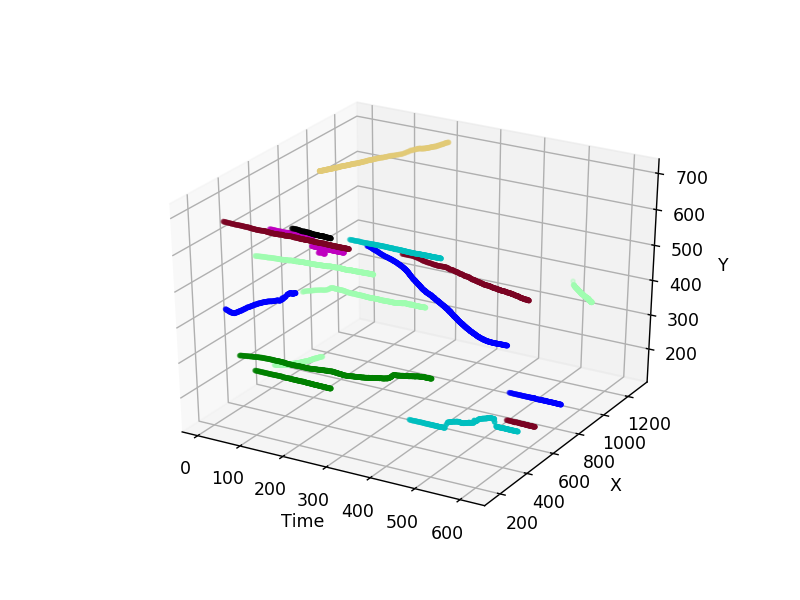

In [105]:
%matplotlib notebook
#tracks = noSmallTubes(tracks)
plotTracks(tracks)
plt.savefig("ski5_pureCSRTmid.png")

In [106]:
#Write the rectangles on the video
for f in range(1,len(V)):
    here = []
    for T in tracks:
        here.extend([t for t in T if t[0]==f])
    if here: #if any track has a box on this frame
        for h in here:
            bbox = h[1]
            p1 = (int(bbox[0]), int(bbox[1]))
            p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
            if h[2]==0:
                cv2.rectangle(V[f], p1, p2, (0,0,255), 2, 1) #red
            elif h[2]==1:
                cv2.rectangle(V[f], p1, p2, (255,0,0), 2, 1) #blue
            else:
                cv2.rectangle(V[f], p1, p2, (0,255,0), 2, 1) #hopefully green


writevid(V,outvidfile) #write the vid to a file

FRAME 10 / 612
FRAME 20 / 612
FRAME 30 / 612
FRAME 40 / 612
FRAME 50 / 612
FRAME 60 / 612
FRAME 70 / 612
FRAME 80 / 612
FRAME 90 / 612
FRAME 100 / 612
FRAME 110 / 612
FRAME 120 / 612
FRAME 130 / 612
FRAME 140 / 612
FRAME 150 / 612
FRAME 160 / 612
FRAME 170 / 612
FRAME 180 / 612
FRAME 190 / 612
FRAME 200 / 612
FRAME 210 / 612
FRAME 220 / 612
FRAME 230 / 612
FRAME 240 / 612
FRAME 250 / 612
FRAME 260 / 612
FRAME 270 / 612
FRAME 280 / 612
FRAME 290 / 612
FRAME 300 / 612
FRAME 310 / 612
FRAME 320 / 612
FRAME 330 / 612
FRAME 340 / 612
FRAME 350 / 612
FRAME 360 / 612
FRAME 370 / 612
FRAME 380 / 612
FRAME 390 / 612
FRAME 400 / 612
FRAME 410 / 612
FRAME 420 / 612
FRAME 430 / 612
FRAME 440 / 612
FRAME 450 / 612
FRAME 460 / 612
FRAME 470 / 612
FRAME 480 / 612
FRAME 490 / 612
FRAME 500 / 612
FRAME 510 / 612
FRAME 520 / 612
FRAME 530 / 612
FRAME 540 / 612
FRAME 550 / 612
FRAME 560 / 612
FRAME 570 / 612
FRAME 580 / 612
FRAME 590 / 612
FRAME 600 / 612
FRAME 610 / 612


In [18]:
T = tracks[3]
h = []
h.extend([t for t in T if t[0]==112])


if h:
    for h2 in h:
        print(h2)

(112, (143.0, 270.0, 77.0, 60.0), True)


In [43]:
cv2.__version__

'3.4.2'